### 4042 Wash Sale A-B-A (Money Pass)

In [1]:
import os; os.chdir('/Users/sqian/MKTSRV')
import pandas as pd; pd.set_option('mode.chained_assignment',None) 
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import re
import xlrd
import matplotlib.cbook as cbook


from src.data_models.smartshelper import metrics, fixType, unSMART, cparty
from src.data_models.SmartsDataModel import SmartsDataModel
from src.utility.DataModelUtility import execute_query_data_frame

/Users/sqian/.pyenv/versions/3.7.0/envs/env_370/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### 0) Fetch & Clean Data from sources:

#### ---> 0A) Import data from: SMARTS BE

In [24]:
alerts_cleaned = pd.read_csv('~/Downloads/DEFAULT_ALERTS.csv')

alerts_cleaned.columns = alerts_cleaned.columns.str.replace(' ','')
alerts_cleaned['longtext'] = alerts_cleaned['longtext'].str.replace('\n','')
alerts_cleaned['Datetime'] = pd.to_datetime(alerts_cleaned['date'].astype(str) + " " + alerts_cleaned['time'].astype(str))

alerts0 = alerts_cleaned.sort_values('Datetime')
alerts0.head(2)

,transid,id,setname,market,startdate,starttime,starttimestamp,date,time,timestamp,...,extrafolder,viewer,commandline,shorttext,longtext,usercode,attachmentfilename,attachmentcontent,isreissue,Datetime
0,1,1,NaN,gemini,2015-10-08,09:43:41.936,2015-10-08 09:43:41.936,2015-10-08,23:59:59.999,2015-10-08 23:59:59.999,...,..,spread,-d 08/10/2015 -t +trading,PRICE DRIVER,PRICE DRIVER DOWN (BROKER): Broker 737 has dec...,NaN,NaN,NaN,f,2015-10-08 23:59:59.999
1,1,1,NaN,gemini,2015-10-11,13:09:25.894,2015-10-11 13:09:25.894,2015-10-11,13:09:25.894,2015-10-11 13:09:25.894,...,..,replay,NaN,BAIT AND SWITCH,BAIT AND SWITCH: The security (BTCUSD) with Br...,NaN,NaN,NaN,f,2015-10-11 13:09:25.894


#### ---> 0B) Filter on Date to get recent alerts

In [3]:
datefilter = (alerts_cleaned['Datetime'] >= datetime.datetime(2019,1,1))
alerts0b = alerts_cleaned.loc[datefilter].reset_index()

print('-> kept ',alerts0b.shape[0],' alerts of ',alerts_cleaned.shape[0],'\n',sep='')
metrics(alerts0b['code'])

-> kept 19532 alerts of 525121



,count,%
4032,8650,44%
4022,8631,44%
4042,2149,11%
1001,63,0%
4012,19,0%


#### ---> 0C) Filter on Scenario to get recent alerts

In [4]:
scenario = 4042
scenariofilter = (alerts0b['code'] == scenario)
alerts0c = alerts0b.loc[scenariofilter].reset_index()

print('-> kept ',alerts0c.shape[0],' alerts of ',alerts0b.shape[0],'\n',sep='')
metrics(alerts0c['code']).head()

-> kept 2149 alerts of 19532



,count,%
4042,2149,100%


### 1) Secondary Clean & Filtering

#### ---> 1A) Expansion of Long Text

In [5]:
for i in range(0,2): print(alerts0c.loc[i,'longtext'],'\n')
alerts0c[['Datetime','shorttext','code','longtext']].to_csv('~/Desktop/1A_Longtext.csv')

WASH SALE A-B-A (MONEY PASS): Broker 69739 and Broker 22440 have executed an ABA wash sale with a time difference of 00:23:24.356:00:44:40.109: Traded x0.5 BTCUSD at $3,683.18000 with a value of $1,842, Broker 22440 (buyer) Broker 69739 (seller).01:08:04.465: Traded x0.5 BTCUSD at $3,692.65000 with a value of $1,846, Broker 69739 (buyer) Broker 22440 (seller).$5 was passed from Broker 69739 to Broker 22440. 

WASH SALE A-B-A (MONEY PASS): Broker 22440 and Broker 202474 have executed an ABA wash sale with a time difference of 00:00:29.612:09:00:45.707: Traded x2 BTCUSD at $3,700.01000 with a value of $7,400, Broker 202474 (buyer) Broker 22440 (seller).09:01:15.319: Traded x2 BTCUSD at $3,672.32000 with a value of $7,345, Broker 22440 (buyer) Broker 202474 (seller).$55 was passed from Broker 202474 to Broker 22440. 



#### ---> 1B) Regex Parse

In [6]:
regex4042 = '.+difference of (\d\d:\d\d:\d\d.\d{3}):(\d\d:\d\d:\d\d.\d{3}):\sTraded\sx([\d.,]+)\s([A-Z]{6})\sat\D+([\d,.]+).+\d\d:\d\d:\d\d.\d{3}:\sTraded\sx[\d,.]+\s[A-Z]{6}\sat\D+([\d,.]+).+passed\D+(\d+)\D+(\d+).+'
name4042 = {0:'diff', 1:'startTime', 2:'vol', 3:'symbol', 4:'price1', 5:'price2',6:'accFROM',7:'accTO'}
alerts1b = pd.concat([alerts0c['longtext'].str.extract(regex4042, expand=True).rename(columns=name4042),alerts0c['Datetime']],axis=1)
alerts1b.head(2)

#### ---> 1C-D) Field Cleanup & Intermediate Calculations

In [7]:
alerts1c = alerts1b.drop(columns=['price1','price2','accFROM','accTO'])
alerts1c['price1'] = alerts1b['price1'].str.replace(',','').astype(float)
alerts1c['price2'] = alerts1b['price2'].str.replace(',','').astype(float)
alerts1c['accFROM'] = alerts1b['accFROM'].astype(int)
alerts1c['accTO'] = alerts1b['accTO'].astype(int)
alerts1c['vol'] = alerts1c['vol'].str.replace(',','').astype(float)
alerts1c['diffMIN'] = pd.to_timedelta(alerts1c['diff']).dt.seconds/60
alerts1c.head(2)

In [8]:
alerts1c['valueBENCH'] = alerts1c[['price1','price2']].min(axis=1) * alerts1c['vol']
alerts1c['pass'] = abs(alerts1c['price1'] - alerts1c['price2']) * alerts1c['vol']
alerts1c['accPOV'] = alerts1c[['accFROM','accTO']].min(axis=1).astype(int)
alerts1c['acc2'] = alerts1c[['accFROM','accTO']].max(axis=1).astype(int)
alerts1c['bool'] = alerts1c['accFROM'] == alerts1c['accPOV']
alerts1c['passPOV'] = (2 * alerts1c['bool'] - 1) * alerts1c['pass']
alerts1c['pass2'] = -alerts1c['passPOV']
alerts1c['tradesum'] = alerts1c[['price1','price2']].sum(axis=1) * alerts1c['vol']
alerts1c['accPAIR'] = alerts1c['accPOV'].astype(str) +'/'+ alerts1c['acc2'].astype(str)
alerts1c['mintradeval'] = alerts1c[['price1','price2']].min(axis=1) * alerts1c['vol']
alerts1c.head()
# alerts2.dtypes

#### ---> 1E) Filter to Replicate Paramter change of: Trade Value >= 5000 and diff <= 15 minutes

In [9]:
tradevalPARAM = 5000
timediffPARAM = 15

tradevalBOOL = alerts1c['mintradeval'] >= tradevalPARAM
timediffBOOL = alerts1c['diffMIN'] <= timediffPARAM

alerts1e = alerts1c.loc[tradevalBOOL & timediffBOOL,]
print('-> kept ',alerts1e.shape[0],' alerts of ',alerts1c.shape[0],' after applying Paramter updates. \n',sep='')

# alerts1e.head()
alerts1c[['mintradeval','diffMIN']].to_csv('~/Desktop/1E_HeatmapData.csv')

-> kept 114 alerts of 2149 after applying Paramter updates. 



#### ---> 1F) Alert Security Distribution (before vs after Parameter change)

In [10]:
pd.concat([metrics(alerts1c['symbol']),metrics(alerts1e['symbol'])],axis=1,sort=False)

,count,%,count,%
BTCUSD,1067,50%,76.0,67%
ETHUSD,890,41%,38.0,33%
ETHBTC,110,5%,NaN,NaN
ZECUSD,47,2%,NaN,NaN
LTCUSD,13,1%,NaN,NaN
LTCBTC,10,0%,NaN,NaN
ZECBTC,6,0%,NaN,NaN
ZECETH,5,0%,NaN,NaN
LTCBCH,1,0%,NaN,NaN


### 2) Preliminary Visualization

#### ---> 2A) First look at time difference

time difference distribution (minutes)


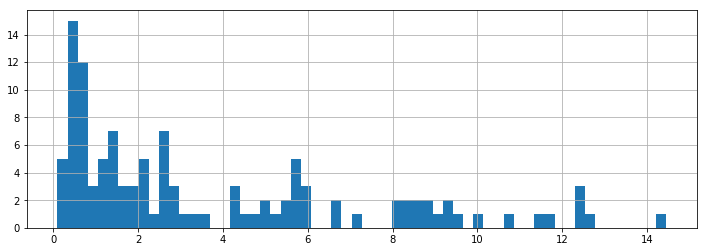

In [11]:
plt.rcParams['figure.figsize'] = (12,4)
print('time difference distribution (minutes)')
alerts1e['diffMIN'].hist(bins=60)

In [12]:
alerts1e['endTime'] = pd.to_timedelta(alerts1e['startTime']) + pd.to_timedelta(alerts1e['diff'])
alerts1e['timedelta'] = (alerts1e['Datetime'] - datetime.datetime(2018,12,31)).dt.total_seconds()/3600/24
alerts1e['startTime2'] = pd.to_timedelta(alerts1e['startTime']).dt.total_seconds()/3600

# alerts1e.head()

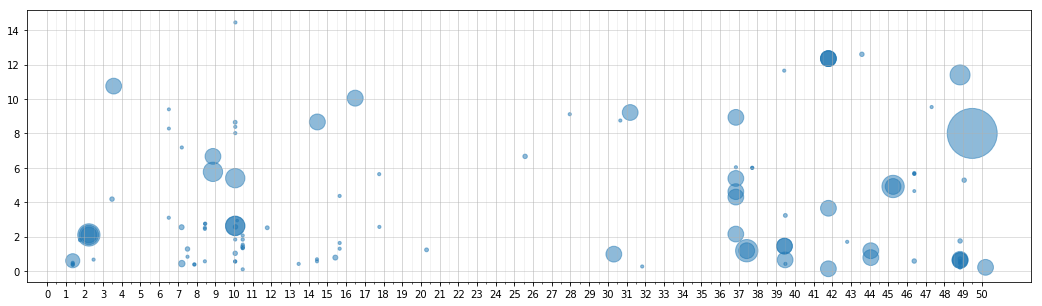

In [13]:
plt.rcParams['figure.figsize'] = (18,5)

fig, ax = plt.subplots()
ax.scatter(alerts1e['timedelta'], alerts1e['diffMIN'], s=alerts1e['vol']*5, alpha=0.5)

major_ticks = np.arange(0, alerts1e['timedelta'].max(),1)
minor_ticks = np.arange(0, alerts1e['timedelta'].max(),.5)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

# ax.xlabel('Label')
# ax1.set_title('ax1 title')
# ax2.set_title('ax2 title')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

plt.show()

###  3) Deep Dive into Accounts Involved:

#### ---> 3A) most frequently encountered accounts

In [14]:
percentageAlerts = 10
alerts3a = pd.Series(alerts1e['accPOV'].append(alerts1e['acc2']))
metrics0 = alerts3a.value_counts()/alerts3a.value_counts().sum()
worstacc = metrics0[metrics0 > percentageAlerts/100].astype(int).index.tolist()

print(metrics(alerts3a).sum()['count'],'total \n')
print((metrics(alerts3a).head()['%']))

accOI = worstacc[0]

228 total 

411770    33%
22440     27%
202474    12%
811415     8%
772544     7%
Name: %, dtype: object


#### ---> 3B) most frequently encountered counterparties of most frequently encountered accounts

In [15]:
account = worstacc[0]

for i in range(0,len(worstacc)): 
    print('account ',worstacc[i],'\n', 
          metrics(alerts3a).loc[worstacc[i],'count'],' total counterparties\n',
          metrics(cparty(alerts1e[['accPOV','acc2']],worstacc[i])).head(),'\n',sep='')

account 411770
75 total counterparties
        count    %
22440      36  48%
811415     15  20%
772544      7   9%
202474      6   8%
355845      6   8%

account 22440
62 total counterparties
        count    %
411770     36  58%
202474     11  18%
355845      9  15%
811415      3   5%
1595        1   2%

account 202474
28 total counterparties
        count    %
22440      11  39%
772544      7  25%
411770      6  21%
1403        1   4%
1595        1   4%



#### ---> 3C) round trip metrics for worst accounts

In [16]:
alerts3cPOV = alerts1e[['acc2','pass2','Datetime','diffMIN','tradesum']].rename(columns={'acc2':'acc','pass2':'pass'})
alerts3c2 = alerts1e[['accPOV','passPOV','Datetime','diffMIN','tradesum']].rename(columns={'accPOV':'acc','passPOV':'pass'})
alerts3c_sub = alerts3cPOV.append(alerts3c2)

countmetrics = alerts3c_sub.groupby('acc').count().sort_values('diffMIN',ascending=False)['diffMIN']
countmetrics = metrics(alerts3c_sub['acc'])

summetrics = round(alerts3c_sub.groupby('acc').sum()[['pass','tradesum']],0).astype(int)
summetrics.columns = summetrics.columns + '_sum'

minmetrics = round(alerts3c_sub.groupby('acc').min()[['Datetime','diffMIN']],3)
minmetrics.columns = minmetrics.columns + '_min'
minmetrics['Datetime_min'] = minmetrics['Datetime_min'].dt.date

avgmetrics = round(alerts3c_sub.groupby('acc').mean()[['diffMIN','pass','tradesum']],0).astype(int)
avgmetrics.columns = avgmetrics.columns + '_avg'

alerts3c = pd.concat([countmetrics,summetrics,minmetrics,avgmetrics],axis=1,sort=True).sort_values('count',ascending=False)
alerts3c

,count,%,pass_sum,tradesum_sum,Datetime_min,diffMIN_min,diffMIN_avg,pass_avg,tradesum_avg
acc,,,,,,,,,
411770,75,33%,-1158,1211269,2019-01-02,0.100,4,-15,16150
22440,62,27%,-178,1532889,2019-01-01,0.200,4,-3,24724
202474,28,12%,999,740575,2019-01-01,0.367,3,36,26449
811415,19,8%,132,300189,2019-01-07,0.100,4,7,15799
772544,16,7%,-1358,239107,2019-01-01,0.383,3,-85,14944
355845,15,7%,188,278281,2019-01-06,0.133,3,13,18552
1595,4,2%,19,87706,2019-01-03,0.267,5,5,21927
1403,3,1%,247,66575,2019-01-02,2.100,2,82,22192
444259,3,1%,2,98842,2019-01-07,0.417,0,1,32947


#### ---> 3D) round trip metrics for worst accounts PAIRS

In [17]:
countmetrics = alerts1e.groupby('accPAIR').count().sort_values('diff',ascending=False)['diff']
countmetrics = metrics(alerts1e['accPAIR'])

summetrics = round(alerts1e.groupby('accPAIR').sum()[['passPOV','tradesum']],0).astype(int)
summetrics.columns = summetrics.columns + '_sum'

minmetrics = round(alerts1e.groupby('accPAIR').min()[['Datetime','diffMIN']],3)
minmetrics.columns = minmetrics.columns + '_min'
minmetrics['Datetime_min'] = minmetrics['Datetime_min'].dt.date

avgmetrics = round(alerts1e.groupby('accPAIR').mean()[['diffMIN','passPOV','tradesum']],0).astype(int)
avgmetrics.columns = avgmetrics.columns + '_avg'

alerts3C = pd.concat([countmetrics,summetrics,minmetrics,avgmetrics],axis=1,sort=True).sort_values('count',ascending=False)
alerts3C.head(10)

,count,%,passPOV_sum,tradesum_sum,Datetime_min,diffMIN_min,diffMIN_avg,passPOV_avg,tradesum_avg
22440/411770,36,32%,368,603265,2019-01-02,0.200,5,10,16757
411770/811415,15,13%,-289,195872,2019-01-07,0.100,4,-19,13058
22440/202474,11,10%,139,445342,2019-01-01,0.367,2,13,40486
22440/355845,9,8%,-163,175668,2019-01-06,0.683,4,-18,19519
411770/772544,7,6%,-88,91670,2019-01-07,0.383,1,-13,13096
202474/772544,7,6%,1175,121989,2019-01-01,0.417,2,168,17427
202474/411770,6,5%,148,98916,2019-01-08,1.533,4,25,16486
355845/411770,6,5%,25,102612,2019-01-10,0.133,2,4,17102
22440/811415,3,3%,230,82933,2019-01-07,1.233,2,77,27644
1595/411770,2,2%,31,59741,2019-01-03,4.183,5,15,29870


### 4) Engine DB Query

In [18]:
# query = "select * from order_fill_event limit 10"

In [19]:
# query = "select count(distinct event_id) from order_fill_event where created >= '2019-1-1' limit 10"
# query2 = "select count(event_id) from order_fill_event where created >= '2019-1-1' limit 10"
# query2 = "select order_fill_event_key, count(*) from order_fill_event where created >= '2019-1-1' group by order_fill_event_key having count(*) > 2"
# query3 = "select * from order_fill_event where event_id = 5278955904"

In [20]:
# # testdata = execute_query_data_frame(query,'engine')
# testdata2 = execute_query_data_frame(query2,'engine')
# testdata3 = execute_query_data_frame(query3,'engine')

In [21]:
# # testdata2['evenid_int'] = testdata2['event_id'].astype(int)
# testdata2

In [22]:
# aggravation: excessive fees

In [23]:
### total traded value for BAD ACCOUNTS and ALL ACCOUNTS AGGREGATELY
### total transactions
### total volume

### average trade value
### average number of trades per day
### average number of order requests per day

### percentage of BAD ACCOUNTS in context of all accounts
### percentage in BAD ACCOUNTS context of all *BIG* accounts